In [64]:
import os
import time
from PIL import Image
from tqdm import tqdm_notebook as tqdm
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms, models, datasets

from torch.utils.data import Dataset, random_split
from torch.optim import lr_scheduler

torch.Size([3, 200, 200])


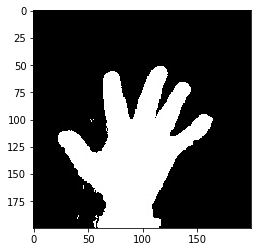

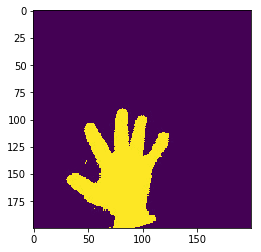

In [91]:
import numpy as np
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import cv2

img = Image.open('gesture_data/five_fingers/2020-01-12-13-45-53.772685.jpg')

data_transform = transforms.Compose([
    transforms.RandomAffine(25,
                            (0.15, 0.15),
                            (0.7, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

img_tr = data_transform(img)
# output = model(image[None, :, :].cuda())
#print(image, image.shape)
print(img_tr.shape)
plt.imshow(img)
plt.show()
plt.imshow(img_tr[0])

In [65]:
torch.cuda.is_available()

True

In [66]:
!ls gesture_data/

fist	      four_fingers  ok		three_fingers
five_fingers  noise	    one_finger	two_fingers


In [67]:
gestures_dict = ('fist', 'five_fingers', 'four_fingers', 'noise', 'ok', 'one_finger', 'three_fingers', 'two_fingers')

In [68]:
len(glob('gesture_data/*/*'))

801

In [69]:
for dirr in glob('gesture_data/*'):
    print(dirr, len(glob(dirr+"/*")))

gesture_data/three_fingers 100
gesture_data/two_fingers 97
gesture_data/five_fingers 99
gesture_data/ok 102
gesture_data/fist 100
gesture_data/noise 102
gesture_data/four_fingers 103
gesture_data/one_finger 98


In [70]:
batch_size=32

In [71]:
data_transform = transforms.Compose([
        transforms.RandomAffine(25, 
                                (0.15, 0.15),
                                (0.7, 1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

gestures_dataset = datasets.ImageFolder(root='gesture_data',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(gestures_dataset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)

fist


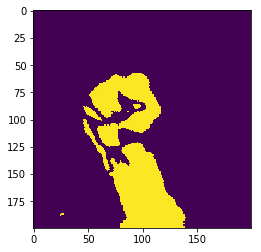

----------------------------------
fist


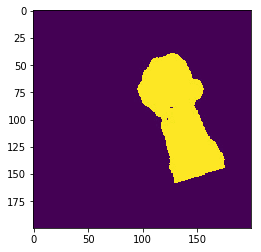

----------------------------------
ok


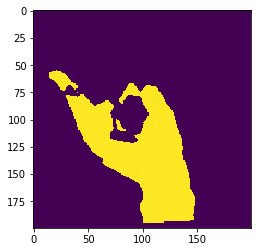

----------------------------------
three_fingers


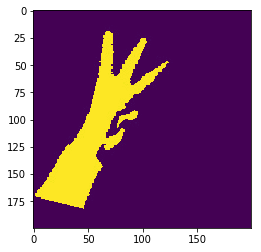

----------------------------------
noise


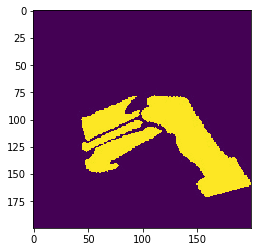

----------------------------------
two_fingers


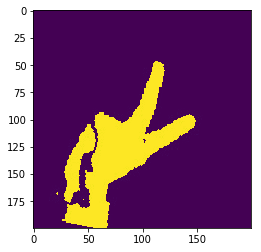

----------------------------------
fist


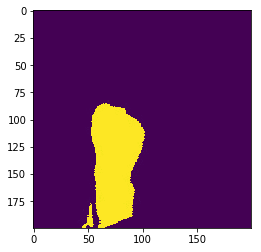

----------------------------------
noise


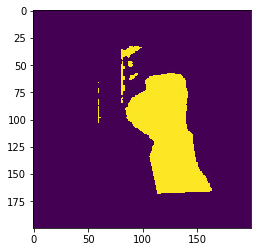

----------------------------------
fist


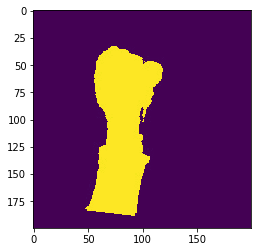

----------------------------------
two_fingers


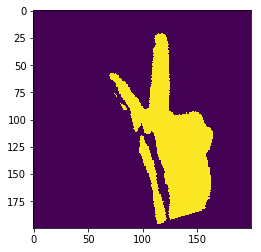

----------------------------------


In [72]:
for i in np.random.randint(0, 808, 10):
    print(gestures_dict[gestures_dataset[i][1]])
    plt.imshow(gestures_dataset[i][0][0])
    plt.show()
    print('----------------------------------')

In [73]:
dataset_length = len(gestures_dataset)

val_size = .2
val_length = int(dataset_length * val_size)

train_data_raw, val_data_raw = random_split(gestures_dataset, [dataset_length - val_length, val_length])

assert isinstance(train_data_raw, torch.utils.data.Dataset)
assert isinstance(val_data_raw, torch.utils.data.Dataset)

In [74]:
train_loader = torch.utils.data.DataLoader(train_data_raw, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_data_raw, batch_size=batch_size, shuffle=True, num_workers=8)

In [75]:
len(train_loader)

21

In [76]:
num_classes = 8

model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, num_classes)
model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2, )

In [77]:
valid_loss_min = np.Inf
patience = 5
n_epochs = 200

#early_stopping_counter
es_counter = 0

stop = False

for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    train_auc = []

    for batch_i, sample_batch in enumerate(train_loader):
        
        #print(sample_batch)
        
        data, target = sample_batch[0].cuda(), sample_batch[1].cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        train_loss.append(loss.item())
        #NEVER WRITE LIKE THIS!!!
        #train_loss.append(loss)
        
        loss.backward()
        optimizer.step()
    
    model.eval()
    val_loss = []
    pred_num = 0
    
    for batch_i, sample_batch in enumerate(val_loader):
        
        data, target = sample_batch[0].cuda(), sample_batch[1].cuda()
        
        #print(data.shape)
        output = model(data)

        loss = criterion(output, target)

        val_loss.append(loss.item()) 
        
        _, predicted = torch.max(output, 1)
        pred_num += (target==predicted).sum()
        
        

    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}, val accuracy: {int(pred_num)/val_length}')
    
    valid_loss = np.mean(val_loss)
    scheduler.step(valid_loss)
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model_4.pth')
        valid_loss_min = valid_loss
        p = 0

    if valid_loss > valid_loss_min:
        p += 1
        print(f'{p} epochs of increasing val loss')
        if p > patience:
            print('Stopping training')
            stop = True
            break        
            
    if stop:
        break

Mon Jan 13 01:37:26 2020 Epoch: 1
Epoch 1, train loss: 2.2388, valid loss: 2.0673, val accuracy: 0.24375
Validation loss decreased (inf --> 2.067269).  Saving model ...
Mon Jan 13 01:37:29 2020 Epoch: 2
Epoch 2, train loss: 1.9041, valid loss: 1.6405, val accuracy: 0.49375
Validation loss decreased (2.067269 --> 1.640513).  Saving model ...
Mon Jan 13 01:37:32 2020 Epoch: 3
Epoch 3, train loss: 1.4105, valid loss: 1.2534, val accuracy: 0.625
Validation loss decreased (1.640513 --> 1.253409).  Saving model ...
Mon Jan 13 01:37:34 2020 Epoch: 4
Epoch 4, train loss: 0.9809, valid loss: 0.9534, val accuracy: 0.66875
Validation loss decreased (1.253409 --> 0.953387).  Saving model ...
Mon Jan 13 01:37:37 2020 Epoch: 5
Epoch 5, train loss: 0.8244, valid loss: 0.7415, val accuracy: 0.7375
Validation loss decreased (0.953387 --> 0.741453).  Saving model ...
Mon Jan 13 01:37:40 2020 Epoch: 6
Epoch 6, train loss: 0.6877, valid loss: 0.6981, val accuracy: 0.775
Validation loss decreased (0.741453

In [78]:
model.load_state_dict(torch.load('best_model_3.pth'))

<All keys matched successfully>

In [47]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [48]:
output = model(gestures_dataset[156][0][None, :, :].cuda())

In [49]:
output

tensor([[-4.6014, 10.8388,  5.1703, -2.6254, -0.5022, -6.6450,  2.3111, -1.2913]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [50]:
torch.argmax(output)

tensor(1, device='cuda:0')

In [79]:
PATH = './best_model_4.pth'
#torch.save(model.state_dict(), PATH)

In [80]:
model = torchvision.models.resnet18()
model.fc = torch.nn.Linear(512, num_classes)
model.load_state_dict(torch.load(PATH))
model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [81]:
len(val_loader)

5

In [82]:
model.eval()
pred_num = 0

labels_all = []
preds_all = []

time_start = time.time()
for val_batch in val_loader:
    
    
    inputs, labels = val_batch[0].cuda(), val_batch[1].cuda()
    
    labels_all += [int(i) for i in labels]
    
    outputs = model(inputs)
    
    _, predicted = torch.max(outputs, 1)
    
    preds_all += [int(i) for i in predicted]
    pred_num += (labels==predicted).sum()

time_end = time.time()

In [83]:
print("Validation time: {:.2f}".format(time_end - time_start))
print("Accuracy: {:.4f}". format(int(pred_num)/val_length))

Validation time: 0.63
Accuracy: 0.9313


In [59]:
from sklearn.metrics import confusion_matrix

In [60]:
preds_all[:5], labels_all[:5]

([6, 7, 6, 6, 2], [6, 7, 6, 2, 2])

In [61]:
cm = confusion_matrix(labels_all, preds_all)
for i in range(8):
    cm[i,i] = 0

In [62]:
import seaborn as sns

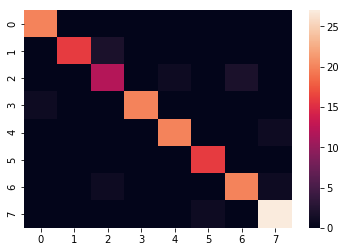

In [63]:
sns.heatmap(confusion_matrix(labels_all, preds_all))

In [53]:
!git clone https://github.com/NVIDIA-AI-IOT/torch2trt

Cloning into 'torch2trt'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 1428 (delta 8), reused 11 (delta 4), pack-reused 1411
Receiving objects: 100% (1428/1428), 272.97 KiB | 913.00 KiB/s, done.
Resolving deltas: 100% (870/870), done.


In [55]:
!ls torch2trt/

benchmarks  LICENSE.md	README.md  test.sh
build.py    notebooks	setup.py   torch2trt


In [56]:
!python torch2trt/setup.py install

running install
running build
running install_egg_info
running egg_info
creating torch2trt.egg-info
writing torch2trt.egg-info/PKG-INFO
writing dependency_links to torch2trt.egg-info/dependency_links.txt
writing top-level names to torch2trt.egg-info/top_level.txt
writing manifest file 'torch2trt.egg-info/SOURCES.txt'
reading manifest file 'torch2trt.egg-info/SOURCES.txt'
writing manifest file 'torch2trt.egg-info/SOURCES.txt'
Copying torch2trt.egg-info to /home/user/anaconda3/envs/envi/lib/python3.7/site-packages/torch2trt-0.0.3-py3.7.egg-info
running install_scripts


In [2]:
from torch2trt import torch2trt

ModuleNotFoundError: No module named 'tensorrt'

In [58]:
import tensorrt

ModuleNotFoundError: No module named 'tensorrt'

In [ ]:
...